# Homerwork 2 - Data from the web

 <span>

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

</span>


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import pairplot

## Question 1

### 1.1

Using Postman, we can easily notice that when we open the ranking another GET request is made to load a txt data file. This file contain all the information displayed in the ranking table. It is formatted as a JSON file, thus we can directly extract the data with request. We can extract from this file: the university name, its rank, its overall score (that we use it later when we merge the two rankings), the country, the region and its detail URL on topuniversities.com.

Regarding international and total number of faculty staffs and students, we need to parse them from the detailed page using BeautifulSoup. All these data is contain in the HTML source in the _div_ with class _qs-profile-2 middle panel-panel_. After that all the specific data we are looking for are stored using the same HTML structure. The numbers are stored in a _div_ of class _number_ inside a _div_ of a specific class. The table below gives in which class we have to look for the data of interest:

|          Feature         | Class |
|:------------------------:|:-----:|
| Total number of faculty staffs |   total faculty    |
|  International faculty staffs  |   inter faculty    |  
| Total number of students |   total student    |   
|  International students  |    total inter   |

We need to have a robust code in the eventuality that the information is not available for some universities. We have two auxiliary functions to parse the detailed page of each university.

- find\_div\_number is used to extract the number for the classes given in the table above. It does check that the class exists before, if it is not the case np.NaN is returned for that specific value.
- parse_uni_details is the main auxiliary function to perform the parsing of the detailed page. Note that the middle pane is extracted for optimization concerns. It avoids to look for the specific classes in the entire HTML structure, but only in a subpart where it is likely to be.

Finally the columns of the dataframe are set in out prefered order and columns representing numerical values (rank, student and faculty data) are converted from _object_ to _numerical_ (int64, float64) types. The entire dataframe is stored in a pickle file to avoid the reader to perform the parsing during the assesment (you will save about 1 minute and 20 seconds of your time).

In [3]:
def find_div_and_number(soup, class_name):
    div = soup.find('div', class_= class_name)
    
    if div is not None:
        return div.find('div', class_='number').text.replace('\n', '').replace(',', '')
    else:
        return np.NaN
        

def parse_uni_details(url):
    page_body = requests.get('https://topuniversities.com' + uni['url']).text

    soup = BeautifulSoup(page_body, "html.parser")
    #optimization: avoid to look everytime in the entire soup to find the classes of interest
    middle_pane = soup.find('div', class_='qs-profile-2 middle panel-panel')
    
    faculty_total = find_div_and_number(middle_pane, 'total faculty')
    faculty_intl  = find_div_and_number(middle_pane, 'inter faculty')
    student_total = find_div_and_number(middle_pane, 'total student')
    student_intl  = find_div_and_number(middle_pane, 'total inter')
    
    return faculty_total, faculty_intl, student_total, student_intl

In [4]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508153509501')
json = r.json()

topuniversities = pd.DataFrame()

for (idx, uni) in enumerate(json['data']):
    
    if int(uni['rank_display'].replace('=', '')) > 200:
        break
        
    faculty_total, faculty_intl, student_total, student_intl = parse_uni_details(uni['url'])
        
    entry = pd.DataFrame({'name': uni['title'], 'rank': uni['rank_display'].replace('=', ''), 'country': uni['country'],
                          'region': uni['region'], 'faculty_intl': faculty_intl, 'faculty_total': faculty_total,
                          'student_intl': student_intl, 'student_total': student_total,
                         'score': uni['score']}, index=[idx]) 
    topuniversities = topuniversities.append(entry)

# Rearrange columns order
topuniversities = topuniversities[['name', 'rank','score', 'country', 'region', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total']]

# Change rank, faculty and student cols to numeric value
cols = ['rank' , 'score' ,'faculty_intl', 'faculty_total', 'student_intl', 'student_total']
topuniversities[cols] = topuniversities[cols].apply(pd.to_numeric)
    
# Serialization as a pickle file
topuniversities.to_pickle('pickled/topuniversities.pkl')

In [5]:
topuniversities = pd.read_pickle('pickled/topuniversities.pkl')
topuniversities.head()

,name,rank,score,country,region,faculty_intl,faculty_total,student_intl,student_total
0,Massachusetts Institute of Technology (MIT),1,100.0,United States,North America,1679.0,2982.0,3717.0,11067.0
1,Stanford University,2,98.7,United States,North America,2042.0,4285.0,3611.0,15878.0
2,Harvard University,3,98.4,United States,North America,1311.0,4350.0,5266.0,22429.0
3,California Institute of Technology (Caltech),4,97.7,United States,North America,350.0,953.0,647.0,2255.0
4,University of Cambridge,5,95.6,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0


We can notice that our newly created dataframe contains only 199 rows even though we wanted the first 200 ranks:

In [6]:
topuniversities.shape

(199, 9)

This is because `topuniversities.com` did a mistake in their ranking. We have three universities tied at rank 195 (representing ranks 195, 196 and 197) which are then followed by rank 199. Thus, there is a missing university at position 198. Either the university with rank 199 is actually rank 198, shifting all the ranking afterwards, or a university is missing. Without further information, we chose not to modify manually the dataframe.

Moreover, the dataframe has only two universities with missing values: _New York University_ for wich we do not have any information regarding the number of international/total students and staffs and the _Indian Institute of Science (IISc) Bangalore_ for which we do not know the number of international faculty members.

In [7]:
topuniversities[topuniversities.isnull().any(1)]

,name,rank,score,country,region,faculty_intl,faculty_total,student_intl,student_total
51,New York University (NYU),52,77.3,United States,North America,NaN,NaN,NaN,NaN
189,Indian Institute of Science (IISc) Bangalore,190,49.0,India,Asia,NaN,423.0,47.0,4071.0


### 1.2

#### a

Lets compute the ratio between faculty members/students and display results for the best 15 universities. The special rank column shows the rank for the current question we are answering. We chose to show only the best 15 because we can show all the elements of the result.

In [8]:
#1.2 a
df_1a = topuniversities.loc[:, ('name', 'rank', 'country', 'region', 'faculty_total', 'student_total')]
df_1a['ratio faculty/students'] = topuniversities.faculty_total / topuniversities.student_total
df_1a = df_1a.sort_values(['ratio faculty/students'], ascending=False)
df_1a['special rank'] = [x + 1 for x in range(df_1a.shape[0])]
df_1a[:15]

,name,rank,country,region,faculty_total,student_total,ratio faculty/students,special rank
3,California Institute of Technology (Caltech),4,United States,North America,953.0,2255.0,0.422616,1
15,Yale University,16,United States,North America,4940.0,12402.0,0.398323,2
5,University of Oxford,6,United Kingdom,Europe,6750.0,19720.0,0.342292,3
4,University of Cambridge,5,United Kingdom,Europe,5490.0,18770.0,0.292488,4
16,Johns Hopkins University,17,United States,North America,4462.0,16146.0,0.276353,5
1,Stanford University,2,United States,North America,4285.0,15878.0,0.269870,6
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,11067.0,0.269450,7
185,University of Rochester,186,United States,North America,2569.0,9636.0,0.266604,8
18,University of Pennsylvania,19,United States,North America,5499.0,20639.0,0.266437,9
17,Columbia University,18,United States,North America,6189.0,25045.0,0.247115,10


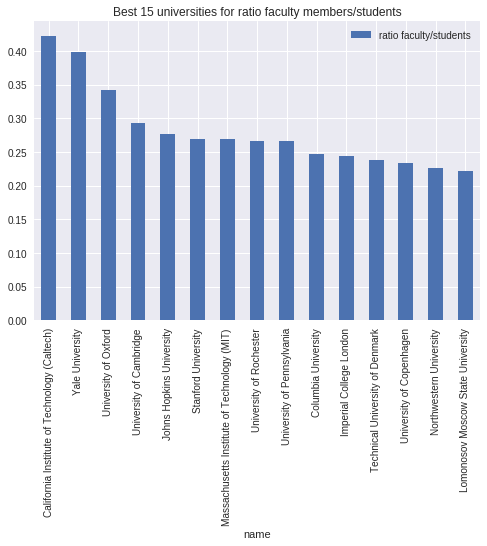

In [9]:
plt.gcf().clear()
df_1a[:15].plot.bar(x = 'name',y='ratio faculty/students', \
                    title='Best 15 universities for ratio faculty members/students').figure

Lets also take a look at the worst 15 universities (note that we do not show the last element of the dataframe which is NYU with a NaN ratio due to its missing values): 

In [10]:
df_1a[-16:-1]

,name,rank,country,region,faculty_total,student_total,ratio faculty/students,special rank
164,"University of California, Irvine",164,United States,North America,1926.0,32151.0,0.059905,184
119,Humboldt-Universität zu Berlin,120,Germany,Europe,1966.0,33198.0,0.059220,185
66,University of Texas at Austin,67,United States,North America,2833.0,47995.0,0.059027,186
196,Texas A&M University,195,United States,North America,3446.0,60294.0,0.057153,187
59,Monash University,60,Australia,Oceania,3204.0,57433.0,0.055787,188
71,KU Leuven,71,Belgium,Europe,2515.0,45538.0,0.055229,189
175,University of Technology Sydney,176,Australia,Oceania,1328.0,24207.0,0.054860,190
69,Georgia Institute of Technology,70,United States,North America,1133.0,21082.0,0.053743,191
152,Université catholique de Louvain (UCL),153,Belgium,Europe,1219.0,24277.0,0.050212,192
151,University of Waterloo,152,Canada,North America,1689.0,35541.0,0.047523,193


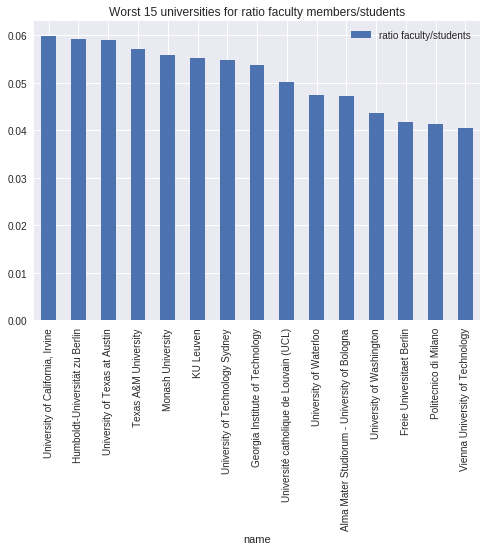

In [11]:
plt.gcf().clear()
df_1a[-16:-1].plot.bar(x = 'name',y='ratio faculty/students', \
                      title='Worst 15 universities for ratio faculty members/students').figure

As we can see the university with the best ratio staff/student is California Institute of Technology (Caltech) and the one with the worst ratio is Vienna University of Technology. 

As a trend we can see that the university that have a good ratio tend to be among the biggest rank : the best 7 ratio all have a rank bellow 20, most of the top 15 have a rank below 100, in the opposite the worst 15 tend to have bad ranks : 7 on 15 have a rank above 150 and most have a rank above 100.

However, we see that even with a bad ratio between faculty member and student, nothing prevent an university to have a good ranking and on the opposite having a good ratio does not mean you have a good rank.

#### b

Lets compute the ratio between international students/total number of students and display results for the best 15 universities.

In [12]:
#1.2 b
df_1b = topuniversities.loc[:, ('name', 'rank', 'country', 'region', 'student_intl', 'student_total')]
df_1b['ratio students_intl/students_total'] = topuniversities.student_intl / topuniversities.student_total
df_1b = df_1b.sort_values(['ratio students_intl/students_total'], ascending=False)
df_1b['special rank']= [x + 1 for x in range(df_1b.shape[0])]
df_1b[:15]

,name,rank,country,region,student_intl,student_total,ratio students_intl/students_total,special rank
34,London School of Economics and Political Scien...,35,United Kingdom,Europe,6748.0,9760.0,0.691393,1
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Switzerland,Europe,5896.0,10343.0,0.570047,2
7,Imperial College London,8,United Kingdom,Europe,8746.0,16090.0,0.543567,3
198,Maastricht University,200,Netherlands,Europe,8234.0,16385.0,0.502533,4
47,Carnegie Mellon University,47,United States,North America,6385.0,13356.0,0.478062,5
6,UCL (University College London),7,United Kingdom,Europe,14854.0,31080.0,0.477928,6
91,University of St Andrews,92,United Kingdom,Europe,4030.0,8800.0,0.457955,7
41,The University of Melbourne,41,Australia,Oceania,18030.0,42182.0,0.427434,8
126,Queen Mary University of London,127,United Kingdom,Europe,6806.0,16135.0,0.421816,9
25,The University of Hong Kong,26,Hong Kong,Asia,8230.0,20214.0,0.407144,10


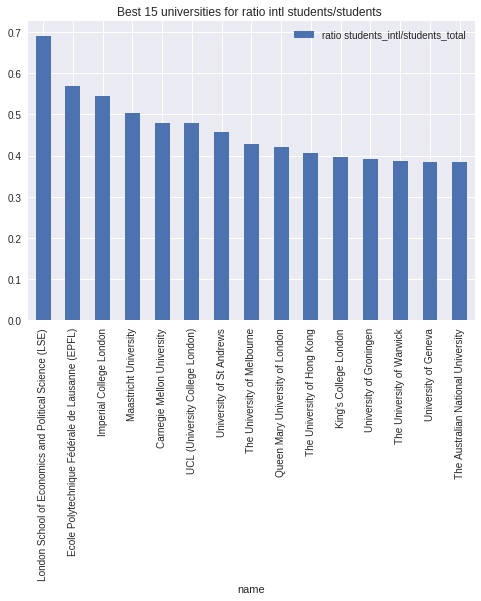

In [13]:
plt.gcf().clear()
df_1b[:15].plot.bar(x = 'name',y='ratio students_intl/students_total', \
                   title = 'Best 15 universities for ratio intl students/students ').figure

Lets also take a look to the worst 15 (without NYU):

In [14]:
df_1b[-16:-1]

,name,rank,country,region,student_intl,student_total,ratio students_intl/students_total,special rank
163,University of Bergen,164,Norway,Europe,767.0,10671.0,0.071877,184
187,Alma Mater Studiorum - University of Bologna,188,Italy,Europe,4195.0,63399.0,0.066168,185
193,Keio University CEMS MIM,192,Japan,Asia,2178.0,33500.0,0.065015,186
144,The Hebrew University of Jerusalem,145,Israel,Asia,1034.0,16531.0,0.062549,187
40,KAIST - Korea Advanced Institute of Science & ...,41,South Korea,Asia,584.0,9826.0,0.059434,188
102,University of Helsinki,102,Finland,Europe,1234.0,22419.0,0.055043,189
70,Pohang University of Science And Technology (P...,71,South Korea,Asia,126.0,3117.0,0.040423,190
137,Pontificia Universidad Católica de Chile (UC),137,Chile,Latin America,991.0,27003.0,0.036700,191
182,Universidade Estadual de Campinas (Unicamp),182,Brazil,Latin America,966.0,26572.0,0.036354,192
96,University of Science and Technology of China,97,China,Asia,548.0,16032.0,0.034182,193


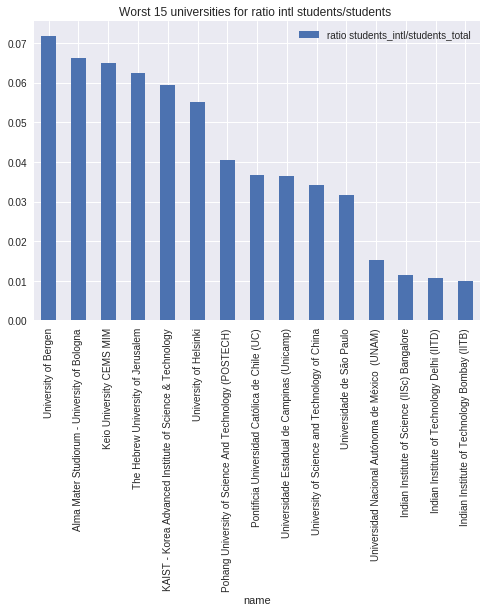

In [15]:
plt.gcf().clear()
df_1b[-16:-1].plot.bar(x = 'name',y='ratio students_intl/students_total', \
                   title = 'Worst 15 universities for ratio intl students/students ').figure

As we can see the university with the best ratio international student/total student is London School of Economics and Political Science (LSE) and the one with the worst ratio is Indian Institute of Technology Bombay (IITB).
Contary to (a) it is more difficult to see a trend for the best ratio but for the worst ratio we can see that most of them have a rank greater than 100.  
So any university can have a good ratio but most of university that have a bad ratio also have a bad rank.

### 1.3

#### c

To calculate the ratio by region and by country, we will just group them by the categorie needed, sum the line in all of the group and calculate the ratios with our results. Auxiliary functions have been written to avoid duplicated code.

In [16]:
def getter(source, by, string1, string2):
    res = topuniversities.groupby(by, as_index=False).sum()
    res[string1] = res[string2] / res['student_total']
    res = res[[by, string1]].sort_values(string1, ascending=False)
    res['special rank'] = [x + 1 for x in range(res.shape[0])]
    return res

In [17]:
#function that calculate the ratio of the number of faculty member compared to the number of student from a dataframe 
#(source) in every value of a column (by) of the dataframe
def getRatioSFBy(source, by):
    return getter(source, by, 'ratio faculty/student', 'faculty_total')

In [18]:
#function that calculate the ratio of the number of international student compared to the total number of student 
#from a dataframe (source) in every value of a column (by) of the dataframe
def getRatioInterBy(source, by):
    return getter(source, by, 'ratio international student', 'student_intl')

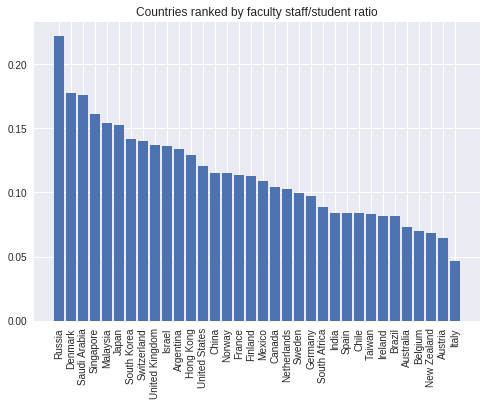

,country,ratio faculty/student,special rank
23,Russia,0.221910,1
8,Denmark,0.177261,2
24,Saudi Arabia,0.175828,3
25,Singapore,0.161530,4
18,Malaysia,0.153893,5
17,Japan,0.152479,6
27,South Korea,0.141721,7
30,Switzerland,0.140434,8
32,United Kingdom,0.136962,9
15,Israel,0.136047,10


In [52]:
#1.3c ratio between faculty members and students
dataex2cSF = getRatioSFBy(topuniversities, 'country')
temp = dataex2cSF

plt.bar(range(len(temp)), temp["ratio faculty/student"])
plt.xticks(range(len(temp)), temp["country"], rotation=90)
plt.title("Countries ranked by faculty staff/student ratio")
plt.show()

temp

In the data above we can see that Italy tends to have the lowest amount of staff per student where Russia seems to have the highest. Other than that there seems to be no correlation between location and staff/student ratio.

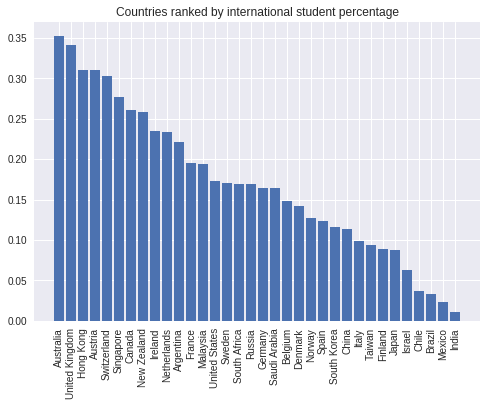

,country,ratio international student,special rank
1,Australia,0.352189,1
32,United Kingdom,0.341705,2
12,Hong Kong,0.310751,3
2,Austria,0.309980,4
30,Switzerland,0.302396,5
25,Singapore,0.276537,6
5,Canada,0.260161,7
21,New Zealand,0.258215,8
14,Ireland,0.235299,9
20,Netherlands,0.232980,10


In [55]:
#1.3 c ratio of international students
dataex2cInter = getRatioInterBy(topuniversities, 'country')
dataex2cInter['special rank'] = [x + 1 for x in range(dataex2cInter.shape[0])]

temp = dataex2cInter

plt.bar(range(len(temp)), temp["ratio international student"])
plt.xticks(range(len(temp)), temp["country"], rotation=90)
plt.title("Countries ranked by international student percentage")
plt.show()

temp[:10]

Countries around the world have extremely varied international student proportions. Richest countries seem to have a slightly higher proportion than poorer ones, but that is not a very pronounced tendancy.

#### d

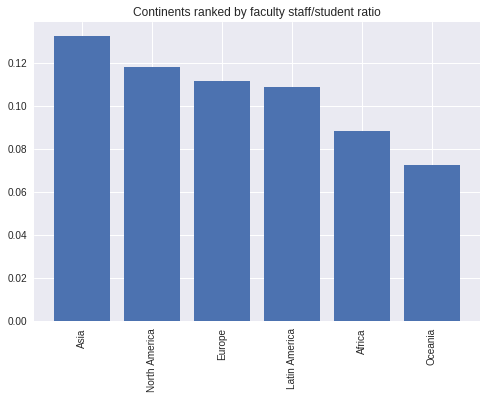

,region,ratio faculty/student,special rank
1,Asia,0.132260,1
4,North America,0.117776,2
2,Europe,0.111564,3
3,Latin America,0.108657,4
0,Africa,0.088450,5
5,Oceania,0.072385,6


In [54]:
#1.3 d ratio between faculty members and students
dataex2dSF = getRatioSFBy(topuniversities, 'region')
dataex2dSF['special rank'] = [x + 1 for x in range(dataex2dSF.shape[0])]

temp = dataex2dSF

plt.bar(range(len(temp)), temp["ratio faculty/student"])
plt.xticks(range(len(temp)), temp["region"], rotation=90)
plt.title("Continents ranked by faculty staff/student ratio")
plt.show()

temp

The more technologically advanced continents have higher faculty staff proportions than less advanced continents.

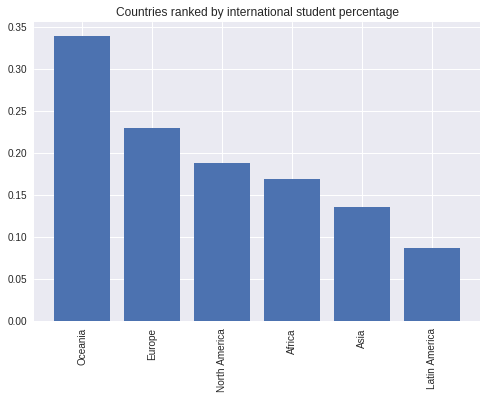

,region,ratio international student,special rank
5,Oceania,0.339261,1
2,Europe,0.229589,2
4,North America,0.188906,3
0,Africa,0.169703,4
1,Asia,0.136431,5
3,Latin America,0.087520,6


In [56]:
#1.3 d ratio of international students
dataex2dInter = getRatioInterBy(topuniversities, 'region')

temp = dataex2dInter

plt.bar(range(len(temp)), temp["ratio international student"])
plt.xticks(range(len(temp)), temp["region"], rotation=90)
plt.title("Countries ranked by international student percentage")
plt.show()

temp

We can see a big difference in internation student ratios in Oceania, probably due to a lower academic population than in other continents. The lower amount of internationals in Asia is probably due to higher prices and distances as well as the cultural and language gap, whereas for Africa and Latin America it is probably due to less opportunities for international students.

## Question 2

Similarly to topuniversities.com, Times Higher Education uses an auxiliary data file (loaded through a sperate GET request) to fill up its ranking table. The THE dataframe is then created using the same methodology than we used for topuniversities.com. Note that this JSON file gives us more insights about the universities than topuniversities.com did. We directly extract the university name, its rank and overall score, the country, the student staff ratio, the percentage of international student, the total number of students and the international outlook score.

Again we finally set the column in our prefered order and convert the numerical columns from type object to numeric (int64/float64). The resulting dataframe is stored as a pickle file to avoid the reader to perform the parsing.

In [23]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
json = r.json()

the = pd.DataFrame()

for (idx, uni) in enumerate(json['data']):
    
    if '201' in uni['rank']:
        break
                
    entry = pd.DataFrame({'name': uni['name'], 'rank': uni['rank'].replace('=', ''), 'country': uni['location'],\
                          'stats_student_staff_ratio': uni['stats_student_staff_ratio'],\
                          'stats_pc_intl_student': uni['stats_pc_intl_students'].replace('%', ''),\
                          'student_total': uni['stats_number_students'].replace(',', ''),\
                          'scores_international_outlook': uni['scores_international_outlook'],\
                         'score': uni['scores_overall']}, index=[idx]) 
    the = the.append(entry)

# Rearrange columns order
the = the[['name', 'rank', 'score', 'country', 'stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total', 'scores_international_outlook']]

# Change rank, faculty and student cols to numeric value
cols = ['rank', 'score', 'stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total', 'scores_international_outlook']
the[cols] = the[cols].apply(pd.to_numeric)
    
# Serialization as a pickle file
the.to_pickle('pickled/the.pkl')

In [24]:
the = pd.read_pickle('pickled/the.pkl')
the.head()

,name,rank,score,country,stats_student_staff_ratio,stats_pc_intl_student,student_total,scores_international_outlook
0,University of Oxford,1,94.3,United Kingdom,11.2,38,20409,95.0
1,University of Cambridge,2,93.2,United Kingdom,10.9,35,18389,93.0
2,California Institute of Technology,3,93.0,United States,6.5,27,2209,59.7
3,Stanford University,3,93.0,United States,7.5,22,15845,77.6
4,Massachusetts Institute of Technology,5,92.5,United States,8.7,34,11177,87.6


No entries in the resulting dataframe has missing values and we do have 200 rows as expected:

In [25]:
the.isnull().any(1).sum()

0

In [26]:
the.shape

(200, 8)

From the 2.1(a) to the 2.1(d) we will just create the dataframe as demanded by the assignement. To calculate the ratio by region and by country, for the international student ratio, we will just find the number of international student by school by multiplying the proportion of international students by the total of students. For the student/staff ratio we will do the same thing but we first need to inverse the stats_student_staff_ratio as it is the inverse of what we want (student / staff, instead of staff / student) and multiply it by 100 to have the result in percent.

For (a) and (b) for the same reason that for ex1 we will show the top 15 ranking and the worst 15 ranking.

In [27]:
#from student / staff to staff / student with %
the['stats_staff_student_ratio'] = the['stats_student_staff_ratio'].map(lambda x : 100/x)

In [28]:
#2.1 (a)  ratio between faculty members and students THE
the_1a = the[['name', 'rank', 'stats_staff_student_ratio']].sort_values(['stats_staff_student_ratio'], ascending=False)
the_1a['special rank'] = [x + 1 for x in range(the_1a.shape[0])]
the_1a[:15]

,name,rank,stats_staff_student_ratio,special rank
105,Vanderbilt University,105,30.303030,1
109,University of Copenhagen,109,24.390244,2
153,University of Rochester,153,23.255814,3
11,Yale University,12,23.255814,4
12,Johns Hopkins University,13,23.255814,5
97,Emory University,98,22.727273,6
16,Duke University,17,22.222222,7
114,École Polytechnique,115,19.607843,8
183,Scuola Normale Superiore di Pisa,184,19.230769,9
101,University of Pittsburgh,100,16.949153,10


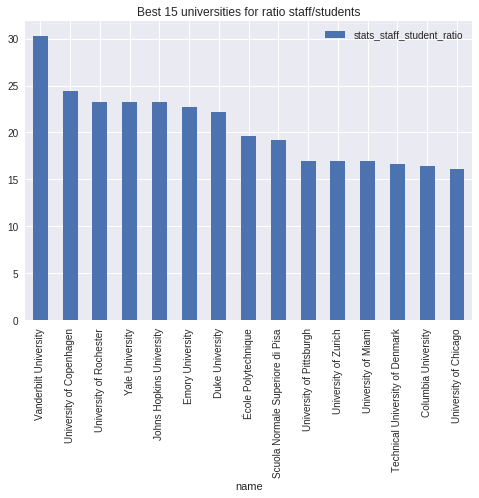

In [29]:
plt.gcf().clear()
the_1a[:15].plot.bar(x = 'name',y='stats_staff_student_ratio', \
                     title='Best 15 universities for ratio staff/students').figure

Lets take a look to the worst 15:

In [30]:
the_1a[-15:]

,name,rank,stats_staff_student_ratio,special rank
46,KU Leuven,47,2.695418,186
128,Université Catholique de Louvain,129,2.645503,187
93,University of Tübingen,94,2.597403,188
81,University of Freiburg,82,2.481390,189
173,University of Münster,173,2.347418,190
174,Université Libre de Bruxelles,175,2.304147,191
144,University of Cologne,145,1.964637,192
40,Technical University of Munich,41,1.838235,193
61,Humboldt University of Berlin,62,1.769912,194
87,Free University of Berlin,88,1.754386,195


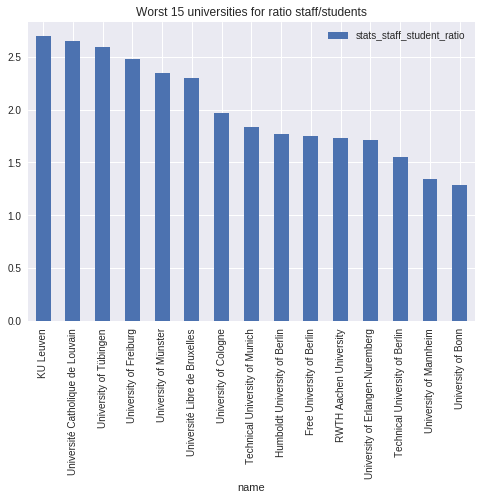

In [31]:
plt.gcf().clear()
the_1a[-15:].plot.bar(x = 'name',y='stats_staff_student_ratio', \
                     title='Worst 15 universities for ratio staff/students').figure

As we can see the university with the best ratio staff/student is Vanderbilt University and the one with the worst ratio is the University of Bonn. For both the top 15 and the worst 15 there is a lot of bad-ranked university with some well ranked university in the top 15. So a bad ranking does not correlate to any ratio but a good ranking mean you are more likely to have a good ranking.

In [32]:
#2.1 (b) ratio of international students
the_1b = the[['name', 'rank', 'stats_pc_intl_student']].sort_values(['stats_pc_intl_student'], ascending=False)
the_1b['special rank'] = [x + 1 for x in range(the_1b.shape[0])]
the_1b[:15]

,name,rank,stats_pc_intl_student,special rank
24,London School of Economics and Political Science,25,71,1
178,University of Luxembourg,179,57,2
37,École Polytechnique Fédérale de Lausanne,38,55,3
7,Imperial College London,8,55,4
102,Maastricht University,103,50,5
15,University College London,16,49,6
143,University of St Andrews,143,48,7
23,Carnegie Mellon University,24,45,8
120,Queen Mary University of London,121,45,9
39,University of Hong Kong,40,42,10


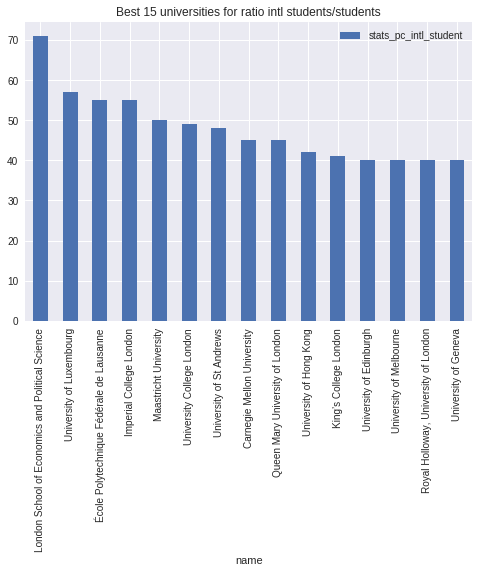

In [33]:
plt.gcf().clear()
the_1b[:15].plot.bar(x = 'name',y='stats_pc_intl_student',\
                    title='Best 15 universities for ratio intl students/students').figure

Lets take a look to the worst 15:

In [34]:
the_1b[-15:]

,name,rank,stats_pc_intl_student,special rank
73,Kyoto University,74,8,186
56,University of North Carolina at Chapel Hill,56,8,187
134,Stockholm University,134,8,188
199,National Taiwan University,198,8,189
183,Scuola Normale Superiore di Pisa,184,7,190
67,Utrecht University,68,7,191
165,Vrije Universiteit Amsterdam,165,7,192
173,University of Münster,173,7,193
167,University of Alabama at Birmingham,168,6,194
177,Zhejiang University,177,6,195


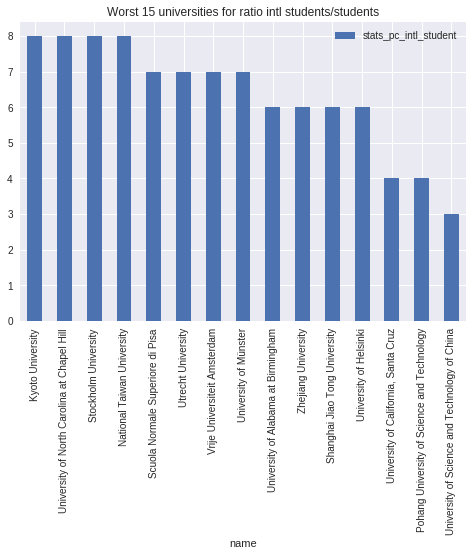

In [35]:
plt.gcf().clear()
the_1b[-15:].plot.bar(x = 'name',y='stats_pc_intl_student',\
                    title='Worst 15 universities for ratio intl students/students').figure

As we can see the university with the best ratio international student/total student is London School of Economics and Political Science and the one with the worst ratio is the University of Science and Technology of China. We can see that in the top 15 even if there is some bad ranking most have a rank below 50 on the other end we can see that for the worst 15 most of the ranking are worst than 150. So if you have a good ranking it is morelikely that you have a lot of international student and if you have a bad ranking you are most likely to have few international student.

So in the end after analysing the the (a) and (b) in both topuniversities and THE we came to different analysis. Those difference come from the fact that a ranking system is different to both but in the end it make it difficult to create trend

In [36]:
def createMeanOnBy(source, on, by):
    res = source.loc[:, [by, on, 'student_total']]
    res.loc[:, on] = res.loc[:, on] * res.loc[:, 'student_total'] 
    res = res.groupby(by, as_index=False).sum()
    res.loc[:, on] = res.loc[:, on] / res.loc[:, 'student_total']
    res = res.sort_values(on, ascending=False)
    res.loc[:, 'special rank'] = [x + 1 for x in range(res.shape[0])]
    return res.loc[:, [by, on, 'special rank']]

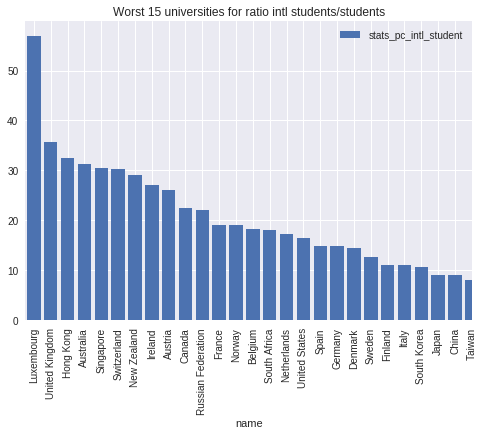

,country,stats_pc_intl_student,special rank
13,Luxembourg,57.000000,1
25,United Kingdom,35.721368,2
9,Hong Kong,32.394821,3
0,Australia,31.199661,4
18,Singapore,30.454520,5
23,Switzerland,30.361950,6
15,New Zealand,29.000000,7
10,Ireland,27.000000,8
1,Austria,26.000000,9
3,Canada,22.415945,10


In [37]:
# 2.1  (c) ratio of international students by country   THE

theRatioInterCount = createMeanOnBy(the, 'stats_pc_intl_student', 'country')

temp = theRatioInterCount

plt.bar(range(len(temp)), temp["stats_pc_intl_student"])
plt.xticks(range(len(temp)), temp["country"], rotation=90)
plt.show()

temp[:10]

As in previous remarks, the lower international population in Asia is probably due to higher prices, longer distances and the cultural and language gap. The spike in Luxembourg probably results from the fact that Luxembourg is a small, rich country with a language common with its neighbors, thus making it a good candidate for international studies without a hassle.

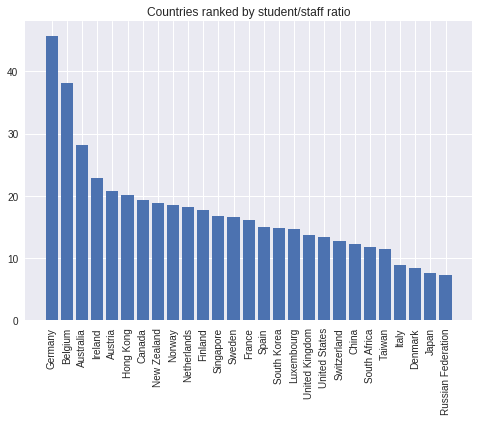

,country,stats_student_staff_ratio,special rank
8,Germany,45.744274,1
2,Belgium,38.127443,2
0,Australia,28.182638,3
10,Ireland,22.800000,4
1,Austria,20.800000,5
9,Hong Kong,20.193949,6
3,Canada,19.378684,7
15,New Zealand,18.800000,8
16,Norway,18.600000,9
14,Netherlands,18.272528,10


In [57]:
# 2.1  (c)  ratio between faculty members and students by country THE 
#theRatioFSCount = the[['name','country','stats_student_staff_ratio']].groupby('country',as_index=False).mean().sort_values(['stats_student_staff_ratio'], ascending= False)
#theRatioFSCount['special rank'] = [x+1 for x in range(theRatioFSCount.shape[0])]

theRatioFSCount = createMeanOnBy(the, 'stats_student_staff_ratio', 'country')

temp = theRatioFSCount

plt.bar(range(len(temp)), temp['stats_student_staff_ratio'])
plt.xticks(range(len(temp)), temp["country"], rotation=90)
plt.title("Countries ranked by student/staff ratio")
plt.show()

temp[:10]

Here we observe a quite low proportion of staff in the left part of the graph, which can be due to various factors, including a efficient administration (could also be due to the exact opposite). Overall most countries seem to be around a student/staff ratio between 5 and 10, with a few of them in very low ratios.

In [39]:
#create a dictionary country -> region from the topuniversities dataFrame because there is no region column for the THE
mapCountryToRegion = topuniversities[['country', 'region']].set_index('country').to_dict(orient='dict')['region']

#there are missing entries so we fill them
mapCountryToRegion['Russian Federation'] = 'Europe'
mapCountryToRegion['Luxembourg'] = 'Europe'

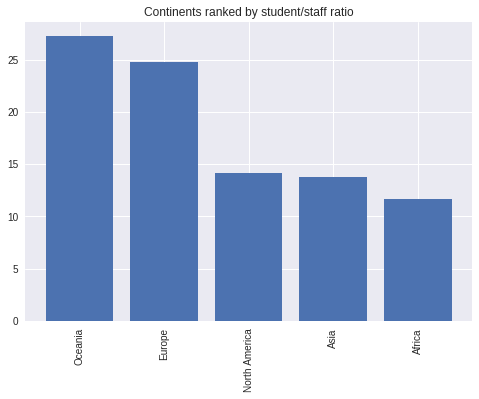

,region,stats_student_staff_ratio,special rank
4,Oceania,27.230246,1
2,Europe,24.759329,2
3,North America,14.189557,3
1,Asia,13.749043,4
0,Africa,11.700000,5


In [58]:
# 2.1  (d)  ratio of international students by country    THE 
theRatioFSRegion = the.copy()
theRatioFSRegion['region'] = theRatioFSRegion['country'].map(mapCountryToRegion)

#theRatioFSRegion = theRatioFSRegion.groupby('region').mean().sort_values(['stats_student_staff_ratio'], ascending= False)
#theRatioFSRegion['special rank'] = [x+1 for x in range(theRatioFSRegion.shape[0])]
theRatioFSRegion = createMeanOnBy(theRatioFSRegion, 'stats_student_staff_ratio', 'region')

temp = theRatioFSRegion

plt.bar(range(len(temp)), temp["stats_student_staff_ratio"])
plt.xticks(range(len(temp)), temp["region"], rotation=90)
plt.title("Continents ranked by student/staff ratio")
plt.show()

temp[:10]

We can carry over some of the previous observations : Oceania has the same lower student population as before, with Africa lacking the same amount of personnel as Asia and Europe.

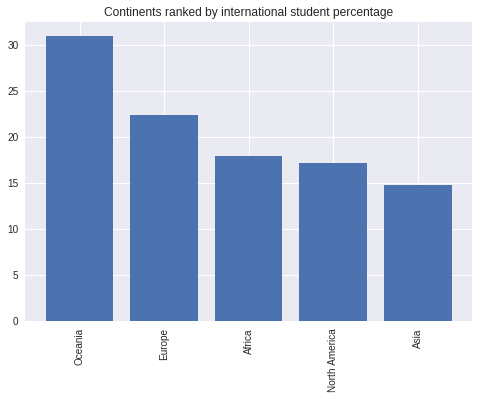

,region,stats_pc_intl_student,special rank
4,Oceania,30.976383,1
2,Europe,22.465653,2
0,Africa,18.000000,3
3,North America,17.201116,4
1,Asia,14.848445,5


In [59]:
# 2.1  (d)  ratio between faculty members and students by country    THE 
theRatioInterRegion = the.copy()
theRatioInterRegion['region'] = theRatioInterRegion['country'].map(mapCountryToRegion)
theRatioInterRegion = createMeanOnBy(theRatioInterRegion, 'stats_pc_intl_student', 'region')

temp = theRatioInterRegion

plt.bar(range(len(temp)), temp["stats_pc_intl_student"])
plt.xticks(range(len(temp)), temp["region"], rotation=90)
plt.title("Continents ranked by international student percentage")
plt.show()

temp

Again, we can carry previous observations, with a large international population for Oceania and a lower one for Asia for the reasons mentioned above. Europe is quite popular as, unlike America, lots of different countries are near each other.

## Question 3

To merge the 2 dataframes we first need for a university to have the same name in both dataframe. To do that we first create a copy of the dataframe of question 1 and 2 so that we can change it without causing problem to the previous code. 

Next there is different universities which name is different in both dataframe but have the same difference (by example  a lot of name in `topuniversities` begin by 'The ' whereas it is not the case in THE) so we can map the name to delete those differences. 

Now we need to map the rest, to do that we created an inner join (that has been now changed to outer in the code so that we can have the full dataframe) of the 2 dataframes to have a list of all the universities that do match, with that we create a list of tuples of universities that does not match and that have the same country (as it will create less tuples so it will be easier to analyse), using them we will be able to find universities that are in both dataframe but does not match because they were named differently and now we just have to change their name in one of the dataframe (here I arbitrarly choose `cleanTopuniversities`) so that they match in a merge.

We keep track of the original position by keeping and differenciate both both rank.

In [42]:
#2.2 merge the dataFrames topuniversities and THE

cleanThe = the.copy()
cleanThe['name'] = cleanThe['name'].map(lambda x : x.replace("’","'").replace('É' , 'E'))

cleanThe.shape

(200, 9)

In [43]:
cleanTopuniversities = topuniversities.copy()
#delete 'The ' at the begginning so that there is more match
cleanTopuniversities['name'] = cleanTopuniversities['name'].map(lambda x : x[4::] if (x[:4] == 'The ') else x.replace('É' , 'E'))
#delete the ' (###)' where ### are the initial of the university at the end of the name
cleanTopuniversities['name'] = cleanTopuniversities['name'].map(lambda x : x.split('(')[0][:-1] if (x[-1] == ')') else x)

#'UCL' : 'University College London'
cleanTopuniversities.loc[6, 'name'] = 'University College London'
#ETH Zurich - Swiss Federal Institute of Technology -> ETH Zurich – Swiss Federal Institute of Technology Zurich 
cleanTopuniversities.loc[9, 'name'] = 'ETH Zurich – Swiss Federal Institute of Technology Zurich'
#KAIST - Korea Advanced Institute of Science & Technology -> Korea Advanced Institute of Science and Technology (KAIST)
cleanTopuniversities.loc[40, 'name'] = 'Korea Advanced Institute of Science and Technology (KAIST)'
#Ludwig-Maximilians-Universität München -> LMU Munich 
cleanTopuniversities.loc[65, 'name'] = 'LMU Munich'
#Ruprecht-Karls-Universität Heidelberg -> Heidelberg University
cleanTopuniversities.loc[67, 'name'] = 'Heidelberg University'
#Pohang University of Science And Technology -> Pohang University of Science and Technology
cleanTopuniversities.loc[71, 'name'] = 'Pohang University of Science and Technology'
#University of North Carolina, Chapel Hill -> University of North Carolina at Chapel Hill 
cleanTopuniversities.loc[79, 'name'] = 'University of North Carolina at Chapel Hill'
#Trinity College Dublin, The University of Dublin -> Trinity College Dublin
cleanTopuniversities.loc[87, 'name'] = 'Trinity College Dublin'
#Washington University in St. Louis -> Washington University in St Louis
cleanTopuniversities.loc[99, 'name'] = 'Washington University in St Louis'
#KIT, Karlsruhe Institute of Technology -> Karlsruhe Institute of Technology
cleanTopuniversities.loc[106, 'name'] = 'Karlsruhe Institute of Technology'
#Sungkyunkwan University -> Sungkyunkwan University (SKKU)
cleanTopuniversities.loc[107, 'name'] = 'Sungkyunkwan University (SKKU)'
#Humboldt-Universität zu Berlin -> Humboldt University of Berlin
cleanTopuniversities.loc[119, 'name'] = 'Humboldt University of Berlin'
#Wageningen University -> Wageningen University & Research
cleanTopuniversities.loc[123, 'name'] = 'Wageningen University & Research'
#Freie Universitaet Berlin -> Free University of Berlin
cleanTopuniversities.loc[124, 'name'] = 'Free University of Berlin'
#Université de Montréal -> University of Montreal
cleanTopuniversities.loc[124, 'name'] = 'University of Montreal'
#Université Pierre et Marie Curie -> Pierre and Marie Curie University
cleanTopuniversities.loc[130, 'name'] = 'Pierre and Marie Curie University'
#Technische Universität Berlin -> Technical University of Berlin
cleanTopuniversities.loc[143, 'name'] = 'Technical University of Berlin'
#Université catholique de Louvain -> Université Catholique de Louvain
cleanTopuniversities.loc[152, 'name'] = 'Université Catholique de Louvain'
#Universitat de Barcelona -> Autonomous University of Barcelona
cleanTopuniversities.loc[155, 'name'] = 'Autonomous University of Barcelona'
#Eberhard Karls Universität Tübingen -> University of Tübingen
cleanTopuniversities.loc[163, 'name'] = 'University of Tübingen'
#Albert-Ludwigs-Universitaet Freiburg -> University of Freiburg
cleanTopuniversities.loc[170, 'name'] = 'University of Freiburg'
#Vrije Universiteit Brussel -> Université Libre de Bruxelles
cleanTopuniversities.loc[181, 'name'] = 'Université Libre de Bruxelles'
#Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento -> Scuola Superiore Sant'Anna
cleanTopuniversities.loc[181, 'name'] = "Scuola Superiore Sant'Anna"

In [44]:
mergeUni = cleanTopuniversities.set_index('name').join(other=cleanThe.set_index('name'), how='outer', lsuffix='_top uni', rsuffix='_THE')
mergeUni

,rank_top uni,score_top uni,country_top uni,region,faculty_intl,faculty_total,student_intl,student_total_top uni,rank_THE,score_THE,country_THE,stats_student_staff_ratio,stats_pc_intl_student,student_total_THE,scores_international_outlook,stats_staff_student_ratio
name,,,,,,,,,,,,,,,,
Aalto University,137.0,56.0,Finland,Europe,370.0,1257.0,1831.0,12147.0,190.0,52.7,Finland,20.2,20.0,12744.0,72.5,4.950495
Aarhus University,119.0,59.3,Denmark,Europe,602.0,2316.0,3762.0,26226.0,109.0,59.4,Denmark,14.3,12.0,25167.0,75.3,6.993007
Alma Mater Studiorum - University of Bologna,188.0,49.1,Italy,Europe,153.0,2990.0,4195.0,63399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.0,58.1,United States,20.1,19.0,44475.0,55.2,4.975124
Australian National University,20.0,87.1,Australia,Oceania,927.0,1600.0,5551.0,14442.0,48.0,71.6,Australia,19.3,35.0,15986.0,94.3,5.181347
Autonomous University of Barcelona,156.0,52.9,Spain,Europe,108.0,3863.0,6134.0,46002.0,147.0,56.2,Spain,12.9,16.0,32309.0,60.1,7.751938
Boston University,81.0,67.2,United States,North America,379.0,3157.0,7041.0,25662.0,70.0,65.4,United States,8.6,25.0,24833.0,60.0,11.627907
Brown University,53.0,76.5,United States,North America,379.0,1303.0,1825.0,9251.0,50.0,70.8,United States,10.7,20.0,8898.0,59.0,9.345794
California Institute of Technology,4.0,97.7,United States,North America,350.0,953.0,647.0,2255.0,3.0,93.0,United States,6.5,27.0,2209.0,59.7,15.384615


In [45]:
#this code is not meant to be run, it is with this code that I was able to create the tuple of univeristies explain
#in the previous paragraph. It is here so that you understand what I was doing.
listOkay = mergeUni.index.values.tolist()
iterTopuniversities = cleanTopuniversities.iterrows()

for itTop in iterTopuniversities:
    iterTheClassment = cleanThe.iterrows()
    topname = itTop[1]['name']
    splittopname = topname.split(' ')
    
    if (not topname in listOkay):
        
        for iterThe in iterTheClassment:
            thename = iterThe[1]['name']
            splitthename = thename.split(' ')
            
            if ((not thename in listOkay) and iterThe[1]['country'] == itTop[1]['country']):
                print(itTop[0], topname, "->", thename, '|')      

## Question 3

In [46]:
#2.3
mergeUni.corr()

,rank_top uni,score_top uni,faculty_intl,faculty_total,student_intl,student_total_top uni,rank_THE,score_THE,stats_student_staff_ratio,stats_pc_intl_student,student_total_THE,scores_international_outlook,stats_staff_student_ratio
rank_top uni,1.000000,-0.978893,-0.531224,-0.316080,-0.305777,-0.047000,0.691762,-0.746637,0.264201,-0.308131,-0.028189,-0.145461,-0.220212
score_top uni,-0.978893,1.000000,0.556515,0.303103,0.284186,0.003284,-0.727989,0.814793,-0.291615,0.337914,-0.017651,0.166735,0.261512
faculty_intl,-0.531224,0.556515,1.000000,0.590178,0.639911,0.312246,-0.358338,0.421648,-0.067153,0.319095,0.261828,0.413189,0.023406
faculty_total,-0.316080,0.303103,0.590178,1.000000,0.471366,0.767247,-0.353308,0.382126,-0.122194,-0.145199,0.593238,-0.185493,0.181028
student_intl,-0.305777,0.284186,0.639911,0.471366,1.000000,0.563177,-0.239047,0.202002,0.212882,0.405795,0.551962,0.385868,-0.320314
student_total_top uni,-0.047000,0.003284,0.312246,0.767247,0.563177,1.000000,-0.112791,0.038659,0.263721,-0.306767,0.936609,-0.275066,-0.338497
rank_THE,0.691762,-0.727989,-0.358338,-0.353308,-0.239047,-0.112791,1.000000,-0.933811,0.107456,-0.214197,-0.151891,-0.101604,-0.152612
score_THE,-0.746637,0.814793,0.421648,0.382126,0.202002,0.038659,-0.933811,1.000000,-0.195985,0.262917,0.079852,0.133871,0.235610
stats_student_staff_ratio,0.264201,-0.291615,-0.067153,-0.122194,0.212882,0.263721,0.107456,-0.195985,1.000000,-0.120413,0.257120,-0.002788,-0.682674
stats_pc_intl_student,-0.308131,0.337914,0.319095,-0.145199,0.405795,-0.306767,-0.214197,0.262917,-0.120413,1.000000,-0.289970,0.799858,0.002730


In the correlation table below, we see obvious, clean (negative because lower ranks match the highest scores) correlation between score and ranks of the same rankings. Between rankings the correlations are still visible, albeit less aligned. Among the ranks and scores, the most disparate couple is `rank_THE` with `rank_top uni`, which disagree on the lower part of the leaderboards, which is understandable (they will generally have sharper rankings of the best universities as they are the ones that will gather the most attention).

Another clean correlation is for the couple `student_total_THE` with `student_total_top uni`, which is again logical since it is rather unlikely that one would disagree on such a figure.

Something we will find on most scatterplots is what was mentioned before for the ranks. We have a relative sense of positive correlation that is less pronounced in the higher values. There is however another reason for that. Unlike for the ranks where the best ranks represent the universities with the most attention, and thus the most precision in regards to the data about it, the others have this phenomenon because the smallest the numbers of students, employees, etc, the least possibilities for variation there is. Where we have a low amount of students, it is much less likely that we will get a significantly higher amount of international students, which is more plausible for a much bigger university.

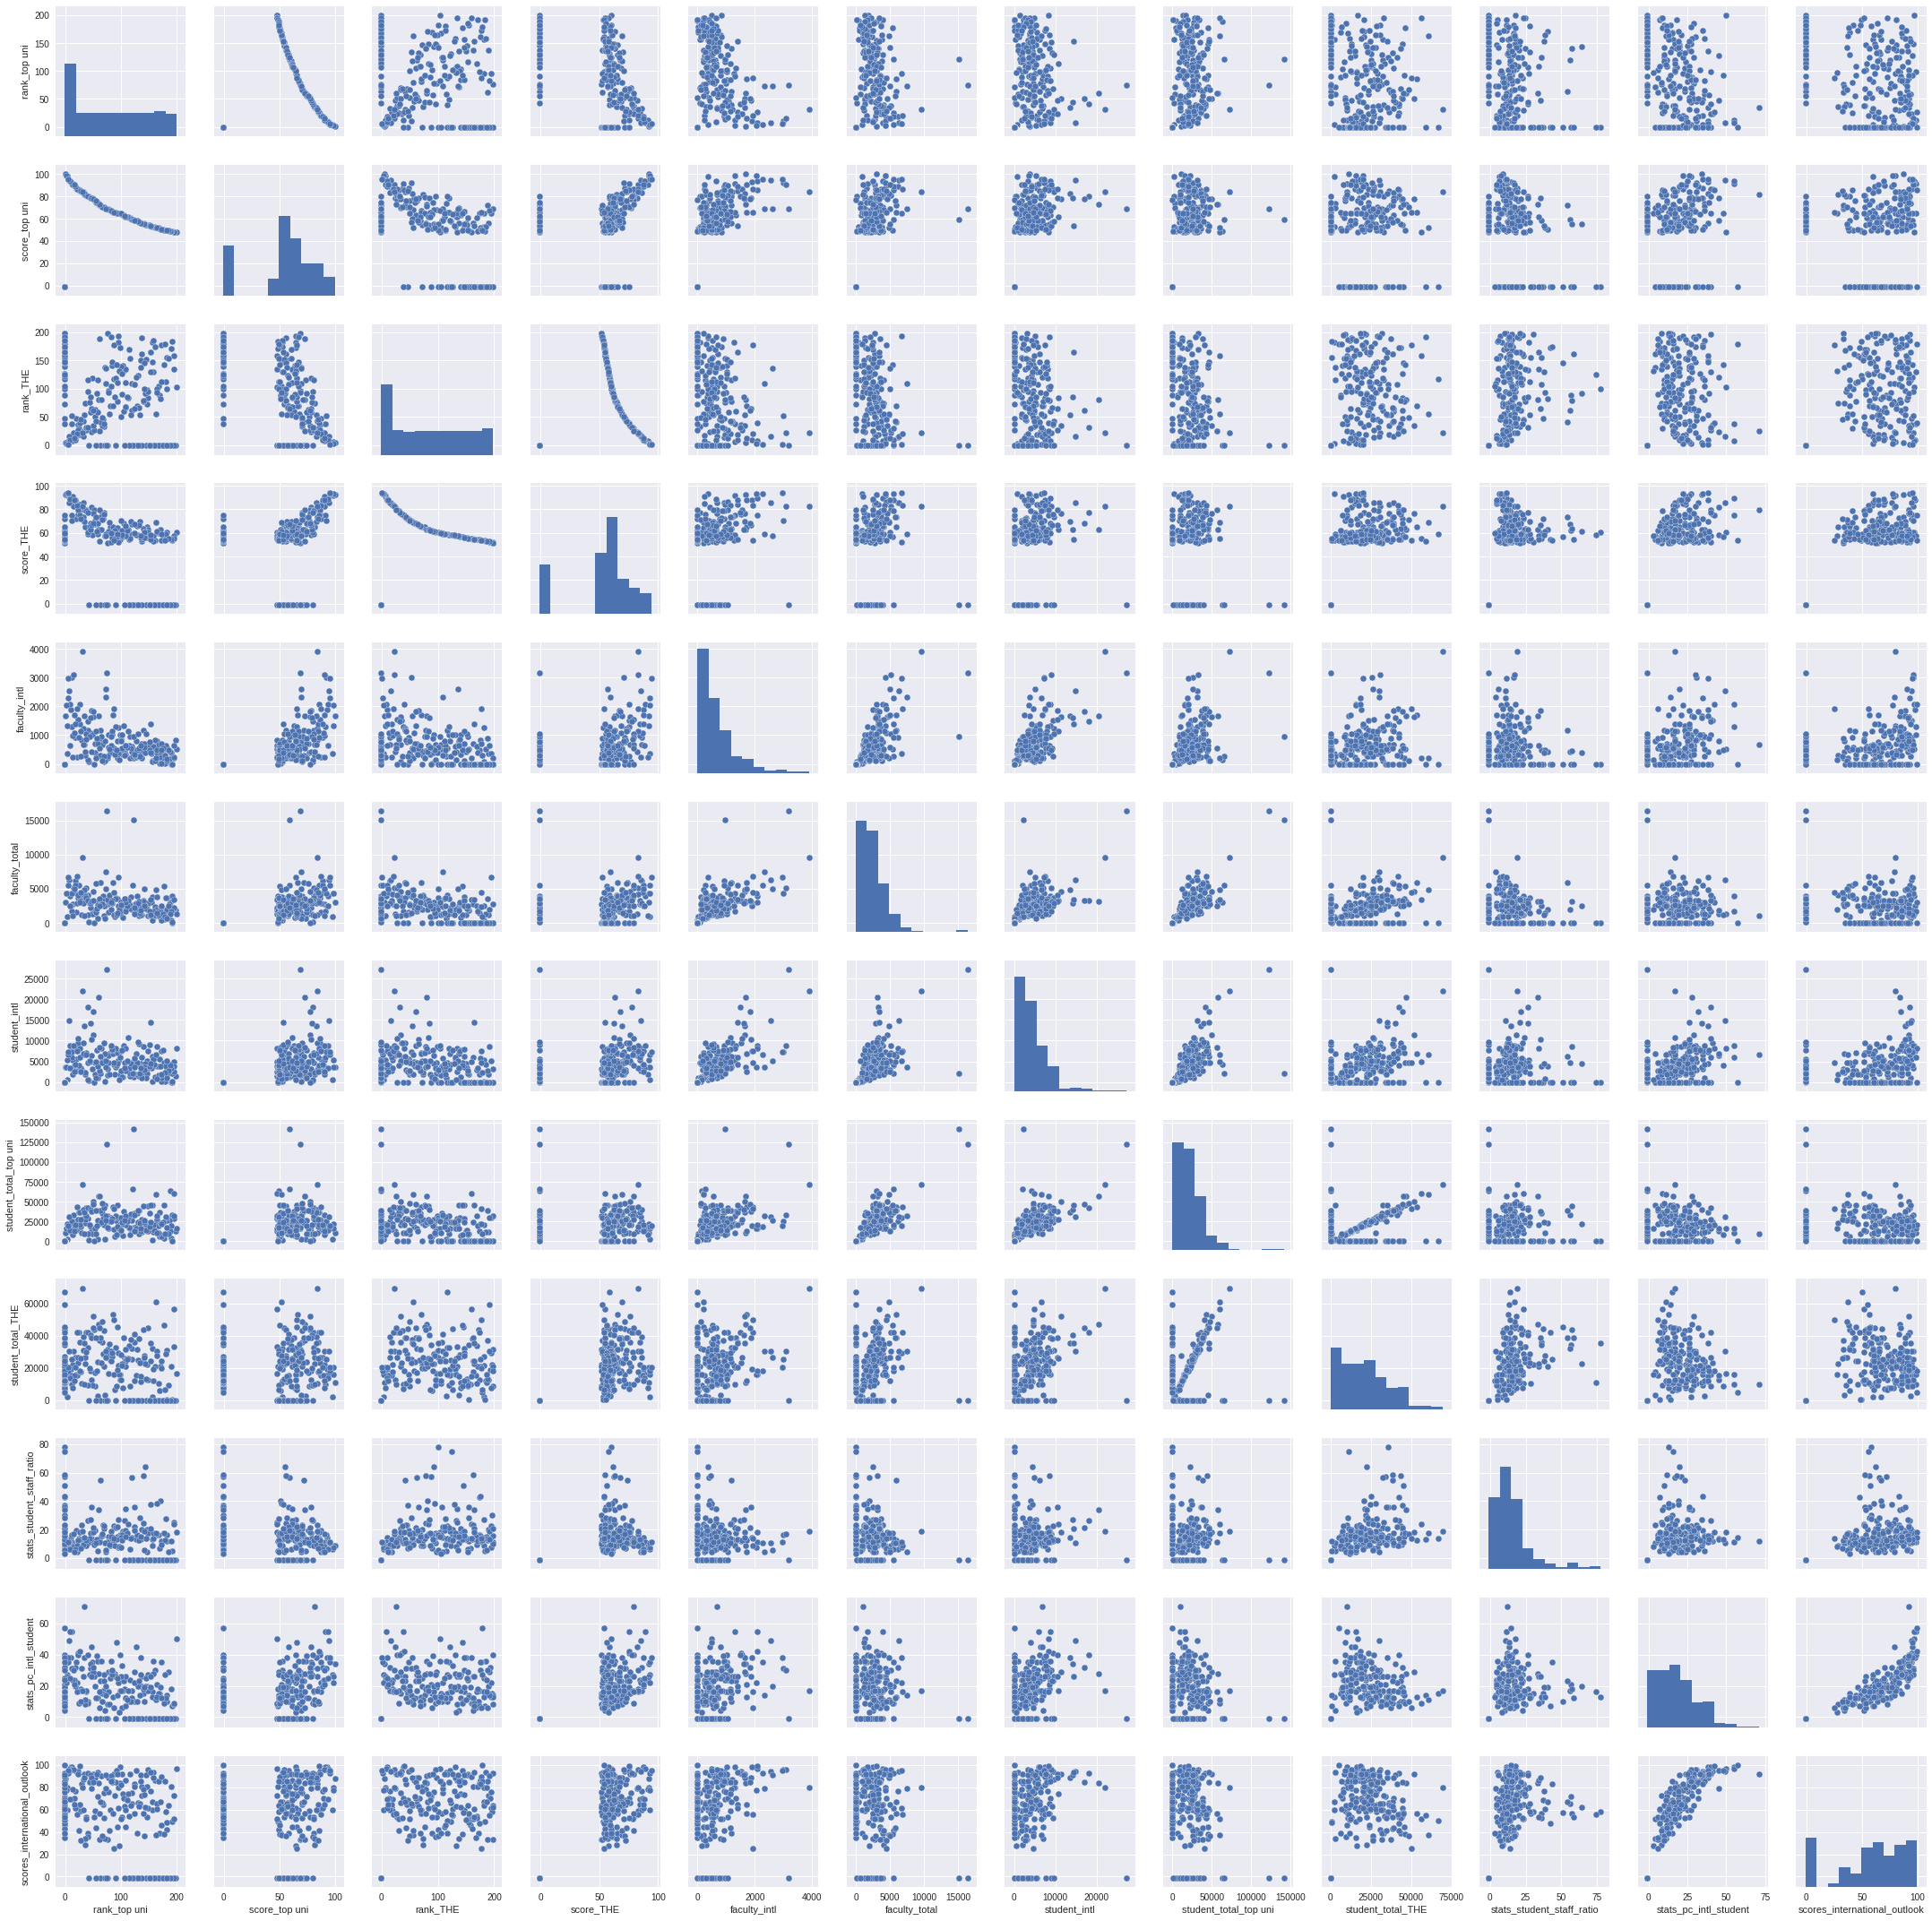

In [47]:
plt.figure()
#numberTopUni= topuniversities[['rank', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total']].dropna()
#numberTopUni.columns = ['rank_top uni', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total_top uni']
#numberThe = the[['rank','stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total', 'scores_international_outlook']].dropna()
#numberThe.columns = ['rank_THE','stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total_THE', 'scores_international_outlook']

#total = pd.concat([numberTopUni , numberThe ] , axis = 1)
pairplot(mergeUni[['rank_top uni', 'score_top uni', 'rank_THE', 'score_THE', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total_top uni', 'student_total_THE', 'stats_student_staff_ratio', 'stats_pc_intl_student', 'scores_international_outlook']].fillna(-1), dropna=True)
#pairplot(total.dropna(),dropna = True)

plt.show()

In [48]:
numberTopUni = topuniversities[['rank', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total']].dropna()
numberTopUni.columns = ['rank_top uni', 'faculty_intl', 'faculty_total', 'student_intl', 'student_total_top uni']
numberThe = the[['rank','stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total', 'scores_international_outlook']].dropna()
numberThe.columns = ['rank_THE','stats_student_staff_ratio', 'stats_pc_intl_student', 'student_total_THE', 'scores_international_outlook']

total = pd.concat([numberTopUni, numberThe], axis=1)
total

,rank_top uni,faculty_intl,faculty_total,student_intl,student_total_top uni,rank_THE,stats_student_staff_ratio,stats_pc_intl_student,student_total_THE,scores_international_outlook
0,1.0,1679.0,2982.0,3717.0,11067.0,1,11.2,38,20409,95.0
1,2.0,2042.0,4285.0,3611.0,15878.0,2,10.9,35,18389,93.0
2,3.0,1311.0,4350.0,5266.0,22429.0,3,6.5,27,2209,59.7
3,4.0,350.0,953.0,647.0,2255.0,3,7.5,22,15845,77.6
4,5.0,2278.0,5490.0,6699.0,18770.0,5,8.7,34,11177,87.6
5,6.0,2964.0,6750.0,7353.0,19720.0,6,8.9,26,20326,79.7
6,7.0,2554.0,6345.0,14854.0,31080.0,7,8.3,24,7955,78.7
7,8.0,2071.0,3930.0,8746.0,16090.0,8,11.4,55,15857,96.6
8,9.0,635.0,2449.0,3379.0,13557.0,9,6.2,25,13525,69.6
9,10.0,1886.0,2477.0,7563.0,19815.0,10,14.6,38,19233,98.1


## Question 4

For finding the best university, we have chosen to calculate the mean of the scores and use it to give a rank for each university.
But first we needed to normalize the scores because it gives too much advantages to the top universities (by example the first of `topuniversities` has a score of 100 whereas the first of THE has a score of 94.3 which is less than the  score of the 5th in `topuniversities`).
After that as we said, we create the mean between the 2 scores to give each university only 1 score to create the ranking.

Note : There is some university that will have nan as a final score because they are not in one of the 2 classment and so we do not have both of their score, we decided to drop those universities from the classment because if they are below the 200th, their score are less than 60 so their final score would not be more than 80 and because the first scores are in the 90s, having those universities would not add more information to find the best university.

In [49]:
#2.4
minTopUni = topuniversities.loc[:, 'score'].min()
maxTopUni = topuniversities.loc[:, 'score'].max()

minThe = the.loc[:, 'score'].min()
maxThe = the.loc[:, 'score'].max()

normalizedScore = mergeUni.loc[:, ['rank_top uni', 'score_top uni', 'rank_THE', 'score_THE', 'total score']]

normalizedScore.loc[:, 'score_top uni'] = (mergeUni.loc[:, 'score_top uni'] - minTopUni) / (maxTopUni - minTopUni) * 100
normalizedScore.loc[:, 'score_THE'] = (mergeUni.loc[:, 'score_THE'] - minThe) / (maxThe - minThe) * 100
normalizedScore['total score'] = (normalizedScore['score_top uni'] + normalizedScore['score_THE']) / 2 
normalizedScore = normalizedScore.sort_values('total score', ascending=False).dropna()
normalizedScore['total rank'] = [i + 1 for i in range(normalizedScore.shape[0])]
normalizedScore.head()

,rank_top uni,score_top uni,rank_THE,score_THE,total score,total rank
name,,,,,,
Massachusetts Institute of Technology,1.0,100.000000,5.0,95.774648,97.887324,1
Stanford University,2.0,97.504798,3.0,96.948357,97.226578,2
California Institute of Technology,4.0,95.585413,3.0,96.948357,96.266885,3
Harvard University,3.0,96.928983,6.0,94.131455,95.530219,4
University of Oxford,6.0,90.978887,1.0,100.000000,95.489443,5


The best university with this method is _Massachusetts Institute of Technology_	

We will now used other methods to find the best Uni :
Let's try to have the mean of the score without normalizing:

In [50]:
meanScore = mergeUni.loc[:, ['rank_top uni', 'score_top uni', 'rank_THE','score_THE', 'total score']]
meanScore['total score'] = (meanScore['score_top uni'] + meanScore['score_THE']) / 2 
meanScore = meanScore.sort_values('total score', ascending=False).dropna()
meanScore.head()

,rank_top uni,score_top uni,rank_THE,score_THE,total score
name,,,,,
Massachusetts Institute of Technology,1.0,100.0,5.0,92.5,96.25
Stanford University,2.0,98.7,3.0,93.0,95.85
California Institute of Technology,4.0,97.7,3.0,93.0,95.35
Harvard University,3.0,98.4,6.0,91.8,95.10
University of Oxford,6.0,95.3,1.0,94.3,94.80


The best university is still _Massachusetts Institute of Technology_.
Now let's try with the mean of the rank :

In [51]:
meanRank = mergeUni.loc[:, ['rank_top uni', 'score_top uni', 'rank_THE', 'score_THE']]
meanRank['total rank'] = (meanRank['rank_top uni'] + meanRank['rank_THE']) / 2 
meanRank = meanRank.sort_values('total rank', ascending=True).dropna()
meanRank.head()

,rank_top uni,score_top uni,rank_THE,score_THE,total rank
name,,,,,
Stanford University,2.0,98.7,3.0,93.0,2.5
Massachusetts Institute of Technology,1.0,100.0,5.0,92.5,3.0
University of Cambridge,5.0,95.6,2.0,93.2,3.5
California Institute of Technology,4.0,97.7,3.0,93.0,3.5
University of Oxford,6.0,95.3,1.0,94.3,3.5


Here we see that it is _Stanford University_ that goes first but that _Massachusetts Institute_ is second. 

Finally it is difficult to point only one best university, here we have a choice between _Massachusetts Institute of Technology_ and _Stanford University_, but the method using the score is better that the method using teh rank because using the score will give a more precise evaluation of an university.

So in the end _Massachusetts Institute of Technology_	can be considered as the best university.